In [1]:
import numpy as np
import pandas as pd
#import tensorflow as tf
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

from fastapi import FastAPI, Request
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer

# EDA

### Loading data

In [2]:
df = pd.read_csv('data/airline_sentiment_analysis.csv', index_col=0)
df.head()

,airline_sentiment,text
1,positive,@VirginAmerica plus you've added commercials t...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."


### Setting sentiment to int values

In [3]:
df['airline_sentiment'] = np.where(df["airline_sentiment"] == "negative", -1, 1)
df.tail()

,airline_sentiment,text
14633,-1,@AmericanAir my flight was Cancelled Flightled...
14634,-1,@AmericanAir right on cue with the delays👌
14635,1,@AmericanAir thank you we got on a different f...
14636,-1,@AmericanAir leaving over 20 minutes Late Flig...
14638,-1,"@AmericanAir you have my money, you change my ..."


### Stripping the airline from the text and making it its own feature

In [4]:
df['Airline'] = df['text'].apply(lambda x: x.split(" ")[0].replace("@", ""))
df['text'] = df['text'].apply(lambda x: ' '.join(x.split(' ')[1:]))
df.head()

,airline_sentiment,text,Airline
1,1,plus you've added commercials to the experienc...,VirginAmerica
3,-1,"it's really aggressive to blast obnoxious ""ent...",VirginAmerica
4,-1,and it's a really big bad thing about it,VirginAmerica
5,-1,seriously would pay $30 a flight for seats tha...,VirginAmerica
6,1,"yes, nearly every time I fly VX this “ear worm...",VirginAmerica


Here we see that most sentiment is negative across all airlines

In [5]:
df['airline_sentiment'].value_counts()

-1    9178
 1    2363
Name: airline_sentiment, dtype: int64

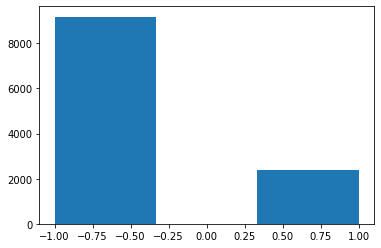

In [6]:
fig = plt.hist(df['airline_sentiment'], bins=3)

### Most frequent words used across all reviews

In [7]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
textt = ' '.join(review for review in df.text) # TODO: make into method vvv
tokens = nltk.word_tokenize(textt)

tokens_l = [w.lower() for w in tokens]

In [9]:
stopW = stopwords.words('english') # TODO: make into method
freq = nltk.FreqDist([w for w in tokens_l if w not in stopW and (w.isalpha() or w.isnumeric())])
top_10 = freq.most_common(10)
top_10

[('flight', 3295),
 ('get', 1100),
 ('cancelled', 958),
 ('thanks', 914),
 ('service', 901),
 ('customer', 721),
 ('help', 698),
 ('time', 680),
 ('http', 653),
 ('hours', 653)]

### Most common words for positve reviews

In [10]:
pos_reviews = df.loc[df['airline_sentiment'] == 1]
pos_text = ' '.join(review for review in pos_reviews.text)
pos_tokens = nltk.word_tokenize(pos_text)
pos_tokens_l =[w.lower() for w in pos_tokens]

In [11]:
pos_freq = nltk.FreqDist([w for w in pos_tokens_l if w not in stopW and (w.isalpha() or w.isnumeric())])
pos_top_10 = pos_freq.most_common(10)
pos_top_10

[('thanks', 605),
 ('thank', 444),
 ('flight', 372),
 ('great', 235),
 ('http', 217),
 ('service', 161),
 ('love', 136),
 ('get', 114),
 ('customer', 113),
 ('much', 109)]

### Most common words for negative reviews

In [12]:
neg_reviews = df.loc[df['airline_sentiment'] == -1]
neg_text = ' '.join(review for review in neg_reviews.text)
neg_tokens = nltk.word_tokenize(neg_text)
neg_tokens_l = [w.lower() for w in neg_tokens]

In [13]:
neg_freq = nltk.FreqDist([w for w in neg_tokens_l if w not in stopW and (w.isalpha() or w.isnumeric())])
neg_top_10 = neg_freq.most_common(10)
neg_top_10

[('flight', 2923),
 ('get', 986),
 ('cancelled', 920),
 ('service', 740),
 ('hours', 646),
 ('help', 614),
 ('hold', 610),
 ('customer', 608),
 ('time', 585),
 ('2', 536)]

# Data Cleaning

In [14]:
def remove_punctuation(text):
    removed = "".join(w for w in text if w not in ("?", "!", ".", ";", ":", ",", '"'))
    return removed

In [15]:
df['text'] = df['text'].apply(remove_punctuation)
df['text']

1        plus you've added commercials to the experienc...
3        it's really aggressive to blast obnoxious ente...
4                 and it's a really big bad thing about it
5        seriously would pay $30 a flight for seats tha...
6        yes nearly every time I fly VX this “ear worm”...
                               ...                        
14633    my flight was Cancelled Flightled leaving tomo...
14634                        right on cue with the delays👌
14635    thank you we got on a different flight to Chicago
14636    leaving over 20 minutes Late Flight No warning...
14638    you have my money you change my flight and don...
Name: text, Length: 11541, dtype: object

# Logistic Regression

In [16]:
X = df['text']
y = df['airline_sentiment']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
vectorizer = CountVectorizer(ngram_range=(1,2), strip_accents='ascii')
train_matrix = vectorizer.fit_transform(X_train)
test_matrix = vectorizer.transform(X_test)

### Training

In [18]:
lr = LogisticRegression()

In [19]:
X_train = train_matrix
X_test = test_matrix

In [20]:
lr.fit(X_train, y_train)

LogisticRegression()

In [21]:
pred = lr.predict(X_test)

### Testing

In [22]:
lr.score(X_test, y_test)

0.9237655212243719

In [23]:
confusion_matrix(pred, y_test)

array([[2712,  205],
       [  59,  487]], dtype=int64)

In [24]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

          -1       0.98      0.93      0.95      2917
           1       0.70      0.89      0.79       546

    accuracy                           0.92      3463
   macro avg       0.84      0.91      0.87      3463
weighted avg       0.94      0.92      0.93      3463



In [25]:
lr.score(X_test, y_test)

0.9237655212243719

In [26]:
s = 'The food on the flight was awful'
lr.predict(vectorizer.transform([s]))[0]

-1

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
param_grid = [
    {'solver': ['lbfgs', 'liblinear'],'max_iter': [75, 100, 125], 'warm_start': [False, True]}    
]
log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')

In [29]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'max_iter': [75, 100, 125],
                          'solver': ['lbfgs', 'liblinear'],
                          'warm_start': [False, True]}],
             scoring='accuracy')

In [30]:
grid_search.best_params_

{'max_iter': 75, 'solver': 'liblinear', 'warm_start': False}

In [31]:
grid_search.best_estimator_

LogisticRegression(max_iter=75, solver='liblinear')

In [32]:
grid_search.score(X_test, y_test)

0.9237655212243719

In [33]:
grid_search.score

<bound method BaseSearchCV.score of GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'max_iter': [75, 100, 125],
                          'solver': ['lbfgs', 'liblinear'],
                          'warm_start': [False, True]}],
             scoring='accuracy')>

In [34]:
phrase = input('Give example review:')
print("Result " + str(grid_search.predict(vectorizer.transform([phrase]))))

Give example review:It was good
Result [1]
